In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import keras.backend as K
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import joblib
from joblib import dump, load
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import MeanSquaredError
from keras.regularizers import l2, l1
from keras.models import model_from_json

In [6]:
print("Se está cargando el dataset, aguarde un momento...")
filePath = "C:/Users/raul.blanco/Documents/4 - Personales/UBA/Repositorios/IA/Trabajo-Final/train_data_n.csv"
train_data_n = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=",")
train_data_n = train_data_n.dropna()
print("El dataset train se cargado correctamente.")

Se está cargando el dataset, aguarde un momento...
El dataset train se cargado correctamente.


In [7]:
print("Se está cargando el dataset, aguarde un momento...")
filePath = "C:/Users/raul.blanco/Documents/4 - Personales/UBA/Repositorios/IA/Trabajo-Final/train_data_u.csv"
train_data_u = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=",")
train_data_u = train_data_u.dropna()
print("El dataset train se cargado correctamente.")

Se está cargando el dataset, aguarde un momento...
El dataset train se cargado correctamente.


In [8]:
#dataset_org = dataset
train_data_n = pd.get_dummies(train_data_n, columns=['source', 'period'], prefix=['source', 'period'])

In [9]:
train_data_n = train_data_n.drop(['timedelta', 'Unnamed: 0'], axis=1)

In [67]:
count = (train_data_n['class'] == 1).sum()
count1 = (train_data_n['class'] == 0).sum()
print(f'En el dataset TRAIN el número de anomalias es {count} y {count1} son valores normales')

En el dataset TRAIN el número de anomalias es 1211373 y 4845491 son valores normales


In [68]:
count = (train_data_u['class'] == 1).sum()
count1 = (train_data_u['class'] == 0).sum()
print(f'En el dataset TRAIN el número de anomalias es {count} y {count1} son valores normales')

En el dataset TRAIN el número de anomalias es 1211373 y 4845491 son valores normales


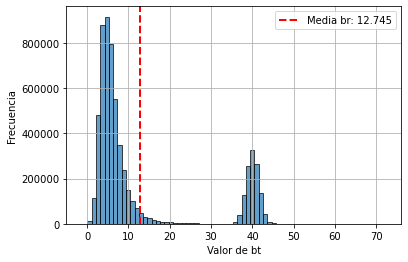

In [11]:
bt_values = train_data_n['bt']
plt.hist(bt_values, bins=70, edgecolor='black', alpha=0.7)
media1 = 12.745
plt.axvline(x=media1, color='r', linestyle='dashed', linewidth=2, label=f'Media br: {media1}')
plt.xlabel('Valor de bt')
plt.ylabel('Frecuencia')
plt.xlim(left=-5, right=76)
plt.grid(True)
plt.legend()
plt.show()

In [12]:
X_train_n = train_data_n.drop('class', axis=1).values
y_train_n = train_data_n['class'].values

Etiqueto los registros que tienen anomalías

In [13]:
X_train_n = pd.DataFrame(X_train_n, columns=['bx_gse', 'by_gse', 'bz_gse', 'theta_gse',
       'phi_gse', 'bx_gsm', 'by_gsm', 'bz_gsm', 'theta_gsm', 'phi_gsm', 'bt',
       'density', 'speed', 'temperature', 'source_ac', 'source_ds', 'period_train_a',
       'period_train_b', 'period_train_c'])
y_train_n = pd.DataFrame(y_train_n, columns = ['Class'])

Undersample

In [ ]:
#X_n = pd.concat([X_train_n, y_train_n], axis=1)

# separate minority and majority classes
#not_anomal = X_n[X_n.Class==0]
#anomal = X_n[X_n.Class==1]

#not_anomal_downsampled_n = resample(not_anomal,
#                                replace = False,
#                                n_samples = len(anomal),
#                                random_state = 27) 

#downsampled_n = pd.concat([not_anomal_downsampled_n, anomal])

In [ ]:
#count = (downsampled_n['Class'] == 1).sum()
#count1 = (downsampled_n['Class'] == 0).sum()
#print(f'En el dataset TRAIN el número de anomalias es {count} y {count1} son valores normales')

In [ ]:
#downsampled.Class.value_counts()

In [ ]:
#y_train_n = downsampled_n.Class
#X_train_n = downsampled_n.drop('Class', axis=1)

upsample

In [ ]:
#X_n = pd.concat([X_train_n, y_train_n], axis=1)

#not_anomal_n = X_n[X_n.Class==0]
#anomal_n = X_n[X_n.Class==1]

# upsample minority
#anomal_upsampled_n = resample(anomal_n,
#                          replace=True,
#                          n_samples=len(not_anomal),
#                          random_state=27)

#upsampled_n = pd.concat([not_anomal_n, anomal_upsampled_n])

In [ ]:
#count = (upsampled_n['Class'] == 1).sum()
#count1 = (upsampled_n['Class'] == 0).sum()
#print(f'En el dataset TRAIN el número de anomalias es {count} y {count1} son valores normales')

In [ ]:
#y_train_n = upsampled_n.Class
#X_train_n = upsampled_n.drop('Class', axis=1)

Aplico PCA

In [14]:
scaler = StandardScaler()
X_train_scaled_n = scaler.fit_transform(X_train_n)
componentes = 9
pca = PCA(n_components = componentes)
X_train_pca_n = pca.fit_transform(X_train_scaled_n)
data_train_X_n = X_train_pca_n
 

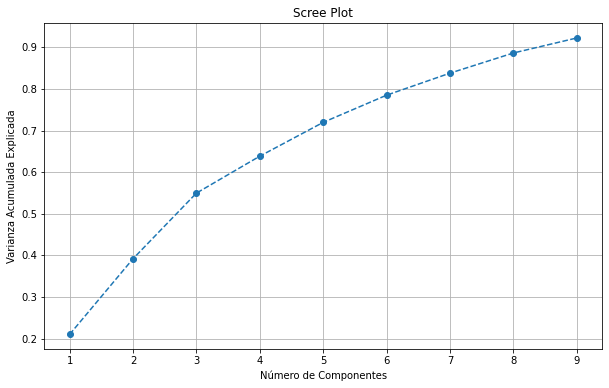

In [15]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.plot(range(1, componentes + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada Explicada')
plt.title('Scree Plot')
plt.xticks(range(1, componentes + 1))
plt.grid(True)
plt.show()

### RBM

Normal

In [16]:
def weighted_mean_squared_error(y_true, y_pred):
    weights = K.cast(K.not_equal(y_true, 0), K.floatx())
    return K.mean(K.square((y_pred - y_true) * weights), axis=-1)  

visible = Input(shape=(data_train_X_n.shape[1],))
#hidden = Dense(64, activation='sigmoid')(visible)
hidden = Dense(16, activation='sigmoid', kernel_regularizer=l1(0.001))(visible)
hidden = Dropout(0.5)(hidden)
hidden = Dense(12, activation='sigmoid', kernel_regularizer=l1(0.001))(visible)
#hidden = Dense(32, activation='sigmoid')(visible)
hidden = Dropout(0.5)(hidden)
visible_recon = Dense(data_train_X_n.shape[1], activation='sigmoid')(hidden)

rbm_model_n = Model(inputs=visible, outputs=visible_recon)
rbm_model_n.compile(optimizer=Adam(learning_rate=0.0001), loss=weighted_mean_squared_error)

In [17]:
start_time = time.time()
hist_rbm_n = rbm_model_n.fit(data_train_X_n, data_train_X_n, epochs=50, batch_size=320, validation_split=0.1)
end_time = time.time()
total_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {total_time:.2f} segundos")

Epoch 1/50
17035/17035 [==============================] - 19s 1ms/step - loss: 1.8294 - val_loss: 1.4926
Epoch 2/50
17035/17035 [==============================] - 17s 1ms/step - loss: 1.7071 - val_loss: 1.4126
Epoch 3/50
17035/17035 [==============================] - 17s 1ms/step - loss: 1.6798 - val_loss: 1.3896
Epoch 4/50
17035/17035 [==============================] - 17s 993us/step - loss: 1.6545 - val_loss: 1.3741
Epoch 5/50
17035/17035 [==============================] - 17s 1ms/step - loss: 1.6374 - val_loss: 1.3434
Epoch 6/50
17035/17035 [==============================] - 19s 1ms/step - loss: 1.6249 - val_loss: 1.3165
Epoch 7/50
17035/17035 [==============================] - 19s 1ms/step - loss: 1.6165 - val_loss: 1.2964
Epoch 8/50
17035/17035 [==============================] - 18s 1ms/step - loss: 1.6098 - val_loss: 1.2857
Epoch 9/50
17035/17035 [==============================] - 19s 1ms/step - loss: 1.6033 - val_loss: 1.2821
Epoch 10/50
17035/17035 [============================

Uniforme

In [ ]:
train_data_u = pd.get_dummies(train_data_u, columns=['source', 'period'], prefix=['source', 'period'])
train_data_u = train_data_u.drop(['timedelta', 'Unnamed: 0'], axis=1)
count = (train_data_u['class'] == 1).sum()
count1 = (train_data_u['class'] == 0).sum()
print(f'En el dataset Train el número de anomalias es {count} y {count1} son valores normales')

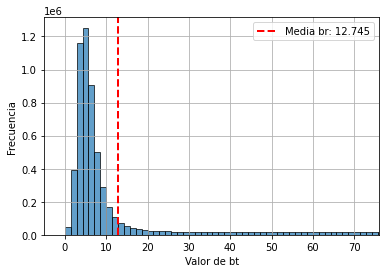

In [19]:
bt_values = train_data_u['bt']
plt.hist(bt_values, bins=70, edgecolor='black', alpha=0.7)
media1 = 12.745
plt.axvline(x=media1, color='r', linestyle='dashed', linewidth=2, label=f'Media br: {media1}')
plt.xlabel('Valor de bt')
plt.ylabel('Frecuencia')
plt.xlim(left=-5, right=76)
plt.grid(True)
plt.legend()
plt.show()

In [20]:
X_train_u = train_data_u.drop('class', axis=1).values
y_train_u = train_data_u['class'].values
X_train_u = pd.DataFrame(X_train_u, columns=['bx_gse', 'by_gse', 'bz_gse', 'theta_gse',
       'phi_gse', 'bx_gsm', 'by_gsm', 'bz_gsm', 'theta_gsm', 'phi_gsm', 'bt',
       'density', 'speed', 'temperature', 'source_ac', 'source_ds', 'period_train_a',
       'period_train_b', 'period_train_c'])
y_train_u = pd.DataFrame(y_train_u, columns = ['Class'])

In [21]:
scaler = StandardScaler()
X_train_scaled_u = scaler.fit_transform(X_train_u)
componentes = 9
pca = PCA(n_components = componentes)
#X_train_pca = pca.fit_transform(X_train)
X_train_pca_u = pca.fit_transform(X_train_scaled_u)
data_train_X_u = X_train_pca_u

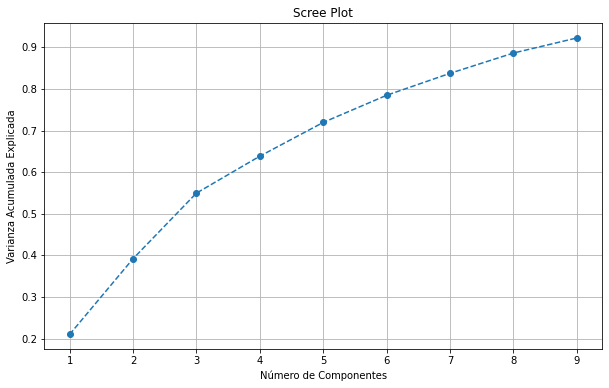

In [22]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.plot(range(1, componentes + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada Explicada')
plt.title('Scree Plot')
plt.xticks(range(1, componentes + 1))
plt.grid(True)
plt.show()

In [23]:
def weighted_mean_squared_error(y_true, y_pred):
    weights = K.cast(K.not_equal(y_true, 0), K.floatx())
    return K.mean(K.square((y_pred - y_true) * weights), axis=-1)  

visible = Input(shape=(data_train_X_u.shape[1],))
#hidden = Dense(64, activation='sigmoid')(visible)
hidden = Dense(16, activation='sigmoid', kernel_regularizer=l1(0.001))(visible)
hidden = Dropout(0.5)(hidden)
hidden = Dense(12, activation='sigmoid', kernel_regularizer=l1(0.001))(visible)
#hidden = Dense(32, activation='sigmoid')(visible)
hidden = Dropout(0.5)(hidden)
visible_recon = Dense(data_train_X_u.shape[1], activation='sigmoid')(hidden)

rbm_model_u = Model(inputs=visible, outputs=visible_recon)
rbm_model_u.compile(optimizer=Adam(learning_rate=0.0001), loss=weighted_mean_squared_error)

In [24]:
start_time = time.time()
hist_rbm_U = rbm_model_u.fit(data_train_X_u, data_train_X_u, epochs=50, batch_size=320, validation_split=0.1)
end_time = time.time()
total_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {total_time:.2f} segundos")

Epoch 1/50
17035/17035 [==============================] - 19s 1ms/step - loss: 1.8420 - val_loss: 1.4501
Epoch 2/50
17035/17035 [==============================] - 19s 1ms/step - loss: 1.6867 - val_loss: 1.3919
Epoch 3/50
17035/17035 [==============================] - 22s 1ms/step - loss: 1.6400 - val_loss: 1.3705
Epoch 4/50
17035/17035 [==============================] - 23s 1ms/step - loss: 1.6186 - val_loss: 1.3606
Epoch 5/50
17035/17035 [==============================] - 24s 1ms/step - loss: 1.6087 - val_loss: 1.3614
Epoch 6/50
17035/17035 [==============================] - 21s 1ms/step - loss: 1.6032 - val_loss: 1.3667
Epoch 7/50
17035/17035 [==============================] - 19s 1ms/step - loss: 1.5982 - val_loss: 1.3669
Epoch 8/50
17035/17035 [==============================] - 21s 1ms/step - loss: 1.5929 - val_loss: 1.3594
Epoch 9/50
17035/17035 [==============================] - 20s 1ms/step - loss: 1.5890 - val_loss: 1.3553
Epoch 10/50
17035/17035 [==============================

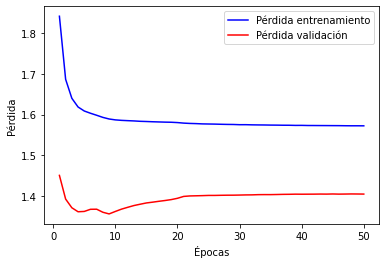

In [125]:
loss = hist_rbm_U.history['loss']
val_loss = hist_rbm_U.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Pérdida entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

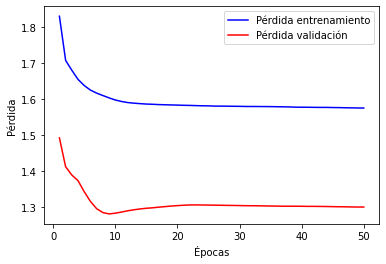

In [128]:
loss = hist_rbm_n.history['loss']
val_loss = hist_rbm_n.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Pérdida entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [25]:
X_train_pred_RBM_n = rbm_model_n.predict(data_train_X_n)
X_train_pred_RBM_u = rbm_model_u.predict(data_train_X_u)

189277/189277 [==============================] - 141s 744us/step


Threshold_u =  3.5
Threshold_n =  3.5


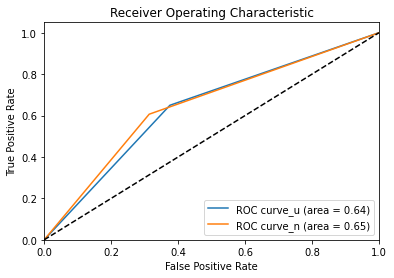

AUC_u: 0.6370836670980616
AUC_n: 0.646445674294069
Threshold =  3.5


In [57]:
threshold_u = float(input("Ingrese el Threshold a utilizar (uniform): "))
print("Threshold_u = ", threshold_u)
y_train_pred_u = np.where(np.linalg.norm(data_train_X_u - X_train_pred_RBM_u, axis=1) > threshold_u, 1, 0)
fpr_u, tpr_u, thresholds = roc_curve(y_train_u, y_train_pred_u)
roc_auc_u = auc(fpr_u, tpr_u)

threshold_n = float(input("Ingrese el Threshold a utilizar (normal): "))
print("Threshold_n = ", threshold_n)
y_train_pred_n = np.where(np.linalg.norm(data_train_X_n - X_train_pred_RBM_n, axis=1) > threshold_n, 1, 0)
fpr_n, tpr_n, thresholds = roc_curve(y_train_n, y_train_pred_n)
roc_auc_n = auc(fpr_n, tpr_n)

#threshold_n = float(input("Ingrese el Threshold a utilizar (normal): "))
#print("Threshold_n = ", threshold_n)
#y_train_pred_n = np.where(np.linalg.norm(data_train_X - X_test_pred_RBM_n, axis=1) > threshold_n, 1, 0)
#fpr_n, tpr_n, thresholds = roc_curve(y_train, y_train_pred_n)
#roc_auc_n = auc(fpr_n, tpr_n)


plt.figure()
plt.plot(fpr_u, tpr_u, label='ROC curve_u (area = %0.2f)' % roc_auc_u)
plt.plot(fpr_n, tpr_n, label='ROC curve_n (area = %0.2f)' % roc_auc_n)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print('AUC_u:', roc_auc_u)
print('AUC_n:', roc_auc_n)
print("Threshold = ", threshold_n)

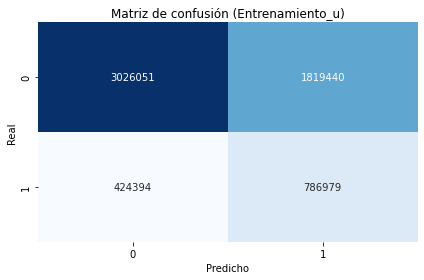

In [66]:
y_train_pred_RBM_u = np.where(np.linalg.norm(data_train_X_u - X_train_pred_RBM_u, axis=1) > threshold_u, 1, 0)

cm_test = confusion_matrix(y_train_u, y_train_pred_RBM_u)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Matriz de confusión (Entrenamiento_u)')
plt.xlabel('Predicho')
plt.ylabel('Real')

plt.tight_layout()
plt.show()

In [60]:
classification_test = classification_report(y_train_u, y_train_pred_RBM_u)
print('Classification Report (Train):\n', classification_test)

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.88      0.62      0.73   4845491
           1       0.30      0.65      0.41   1211373

    accuracy                           0.63   6056864
   macro avg       0.59      0.64      0.57   6056864
weighted avg       0.76      0.63      0.67   6056864



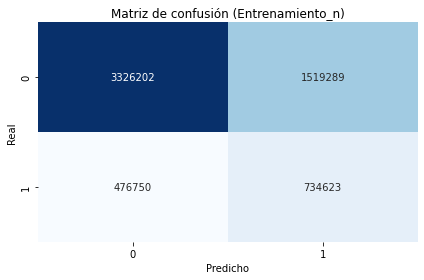

In [69]:
y_train_pred_RBM_n = np.where(np.linalg.norm(data_train_X_n - X_train_pred_RBM_n, axis=1) > threshold_n, 1, 0)

cm_test = confusion_matrix(y_train_n, y_train_pred_RBM_n)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Matriz de confusión (Entrenamiento_n)')
plt.xlabel('Predicho')
plt.ylabel('Real')

plt.tight_layout()
plt.show()

In [70]:
classification_test = classification_report(y_train_n, y_train_pred_RBM_n)
print('Classification Report (Train):\n', classification_test)

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.87      0.69      0.77   4845491
           1       0.33      0.61      0.42   1211373

    accuracy                           0.67   6056864
   macro avg       0.60      0.65      0.60   6056864
weighted avg       0.76      0.67      0.70   6056864



In [81]:
name = input("Ingrese el nombre de los archivos a generar sin extención para el modelo RBM: ")
model_json = rbm_model_u.to_json()
with open(f"{name}.json", "w") as json_file:
    json_file.write(model_json)
rbm_model_u.save_weights(f"{name}.h5")
print("Modelo guardado localmente")

Modelo guardado en el PC


In [82]:
name = input("Ingrese el nombre de los archivos a generar sin extención para el modelo RBM: ")
model_json = rbm_model_n.to_json()
with open(f"{name}.json", "w") as json_file:
    json_file.write(model_json)
rbm_model_n.save_weights(f"{name}.h5")
print("Modelo guardado localmente")

Modelo guardado en el PC


### LSTM

Uniforme

In [27]:
X_train_3d_u = X_train_pca_u.reshape(X_train_pca_u.shape[0], 1, X_train_pca_u.shape[1])

In [28]:
def weighted_mean_squared_error(y_true, y_pred):
    weights = K.cast(K.not_equal(y_true, 0), K.floatx())
    return K.mean(K.square((y_pred - y_true) * weights), axis=-1)   


input_dim = X_train_3d_u.shape[2]
timesteps = X_train_3d_u.shape[1]

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(64, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(32, activation='relu', return_sequences=True)(encoded)
encoded = LSTM(8, activation='relu', return_sequences=False)(encoded) 
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(8, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(input_dim, activation='linear', return_sequences=True)(decoded)
autoencoder_u = Model(inputs, decoded)
autoencoder_u.compile(optimizer='adam', loss=weighted_mean_squared_error)

In [29]:
start_time = time.time()
hist_LSTM_u = autoencoder_u.fit(X_train_3d_u, X_train_3d_u, epochs=25, batch_size=320, validation_split=0.1)
end_time = time.time()
total_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {total_time:.2f} segundos")

Epoch 1/25
17035/17035 [==============================] - 292s 17ms/step - loss: 0.1515 - val_loss: 0.0125
Epoch 2/25
17035/17035 [==============================] - 275s 16ms/step - loss: 0.0412 - val_loss: 0.0089
Epoch 3/25
17035/17035 [==============================] - 273s 16ms/step - loss: 0.0392 - val_loss: 0.0084
Epoch 4/25
17035/17035 [==============================] - 288s 17ms/step - loss: 0.0386 - val_loss: 0.0081
Epoch 5/25
17035/17035 [==============================] - 308s 18ms/step - loss: 0.0382 - val_loss: 0.0085
Epoch 6/25
17035/17035 [==============================] - 329s 19ms/step - loss: 0.0349 - val_loss: 0.0083
Epoch 7/25
17035/17035 [==============================] - 389s 23ms/step - loss: 0.0317 - val_loss: 0.0079
Epoch 8/25
17035/17035 [==============================] - 389s 23ms/step - loss: 0.0315 - val_loss: 0.0077
Epoch 9/25
17035/17035 [==============================] - 370s 22ms/step - loss: 0.0314 - val_loss: 0.0079
Epoch 10/25
17035/17035 [============

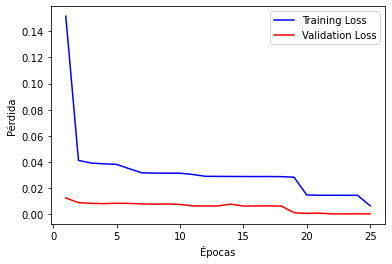

In [55]:
loss = hist_LSTM_u.history['loss']
val_loss = hist_LSTM_u.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


Normal

In [30]:
X_train_3d_n = X_train_pca_n.reshape(X_train_pca_n.shape[0], 1, X_train_pca_n.shape[1])

In [88]:
def weighted_mean_squared_error(y_true, y_pred):
    weights = K.cast(K.not_equal(y_true, 0), K.floatx())
    return K.mean(K.square((y_pred - y_true) * weights), axis=-1)   


input_dim = X_train_3d_n.shape[2]
timesteps = X_train_3d_n.shape[1]

inputs = Input(shape=(timesteps, input_dim))
encoded = LSTM(64, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(32, activation='relu', return_sequences=True)(encoded)
encoded = LSTM(8, activation='relu', return_sequences=False)(encoded) 
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(8, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(input_dim, activation='linear', return_sequences=True)(decoded)
autoencoder_n = Model(inputs, decoded)
autoencoder_n.compile(optimizer='adam', loss=weighted_mean_squared_error)

In [89]:
start_time = time.time()
hist_LSTM_n = autoencoder_n.fit(X_train_3d_n, X_train_3d_n, epochs=25, batch_size=320, validation_split=0.1)
end_time = time.time()
total_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {total_time:.2f} segundos")

Epoch 1/25
17035/17035 [==============================] - 155s 9ms/step - loss: 0.1960 - val_loss: 0.0329
Epoch 2/25
17035/17035 [==============================] - 153s 9ms/step - loss: 0.0189 - val_loss: 0.0141
Epoch 3/25
17035/17035 [==============================] - 164s 10ms/step - loss: 0.0140 - val_loss: 0.0043
Epoch 4/25
17035/17035 [==============================] - 167s 10ms/step - loss: 0.0119 - val_loss: 0.0035
Epoch 5/25
17035/17035 [==============================] - 168s 10ms/step - loss: 0.0109 - val_loss: 0.0028
Epoch 6/25
17035/17035 [==============================] - 170s 10ms/step - loss: 0.0106 - val_loss: 0.0024
Epoch 7/25
17035/17035 [==============================] - 169s 10ms/step - loss: 0.0091 - val_loss: 0.0037
Epoch 8/25
17035/17035 [==============================] - 174s 10ms/step - loss: 0.0080 - val_loss: 0.0018
Epoch 9/25
17035/17035 [==============================] - 182s 11ms/step - loss: 0.0079 - val_loss: 0.0015
Epoch 10/25
17035/17035 [==============

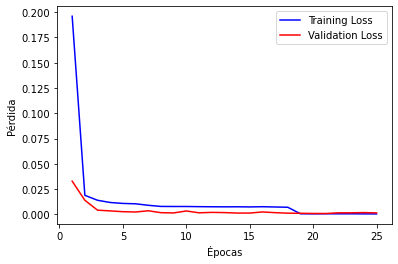

In [90]:
loss = hist_LSTM_n.history['loss']
val_loss = hist_LSTM_n.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [94]:
X_train_pred_LSTM_u = autoencoder_u.predict(X_train_3d_u)
X_train_pred_LSTM_n = autoencoder_n.predict(X_train_3d_n)

189277/189277 [==============================] - 409s 2ms/step


Threshold_u =  0.045
Threshold_n =  0.3


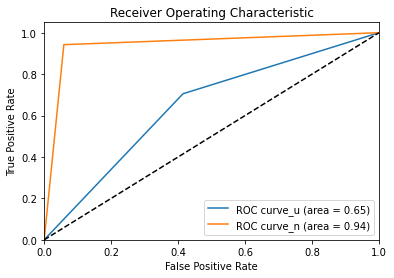

AUC_u: 0.6453515541233412
AUC_n: 0.9417866071485818


In [123]:
threshold_u = float(input("Ingrese el Threshold a utilizar (uniform): "))
print("Threshold_u = ", threshold_u)
y_train_pred_lstm_u = np.where(np.linalg.norm(X_train_3d_u - X_train_pred_LSTM_u, axis=(1, 2)) > threshold_u, 1, 0)

fpr_u, tpr_u, thresholds = roc_curve(y_train_u, y_train_pred_lstm_u)
roc_auc_u = auc(fpr_u, tpr_u)

#threshold_n = float(input("Ingrese el Threshold a utilizar (normal): "))
#print("Threshold_n = ", threshold_n)
#y_train_pred_n = np.where(np.linalg.norm(data_train_X_n - X_train_pred_RBM_n, axis=1) > threshold_n, 1, 0)
#fpr_n, tpr_n, thresholds = roc_curve(y_train_n, y_train_pred_n)
#roc_auc_n = auc(fpr_n, tpr_n)

threshold_n = float(input("Ingrese el Threshold a utilizar (normal): "))
print("Threshold_n = ", threshold_n)
y_train_pred_lstm_n = np.where(np.linalg.norm(X_train_3d_u - X_train_pred_LSTM_n, axis=(1, 2)) > threshold_n, 1, 0)
fpr_n, tpr_n, thresholds = roc_curve(y_train_n, y_train_pred_lstm_n)
roc_auc_n = auc(fpr_n, tpr_n)


plt.figure()
plt.plot(fpr_u, tpr_u, label='ROC curve_u (area = %0.2f)' % roc_auc_u)
plt.plot(fpr_n, tpr_n, label='ROC curve_n (area = %0.2f)' % roc_auc_n)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print('AUC_u:', roc_auc_u)
print('AUC_n:', roc_auc_n)

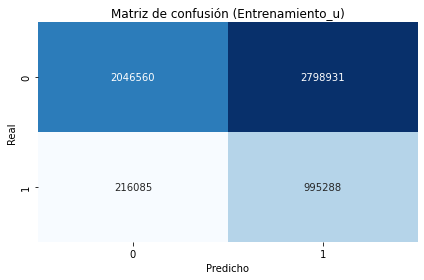

In [113]:
y_train_pred_LSTM_u = np.where(np.linalg.norm(X_train_3d_u - X_train_pred_LSTM_u, axis=(1, 2)) > threshold_u, 1, 0)

cm_test = confusion_matrix(y_train_u, y_train_pred_LSTM_u)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Matriz de confusión (Entrenamiento_u)')
plt.xlabel('Predicho')
plt.ylabel('Real')

plt.tight_layout()
plt.show()

In [114]:
classification_train = classification_report(y_train_u, y_train_pred_LSTM_u)
print('Classification Report (Train):\n', classification_train)

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.90      0.42      0.58   4845491
           1       0.26      0.82      0.40   1211373

    accuracy                           0.50   6056864
   macro avg       0.58      0.62      0.49   6056864
weighted avg       0.78      0.50      0.54   6056864



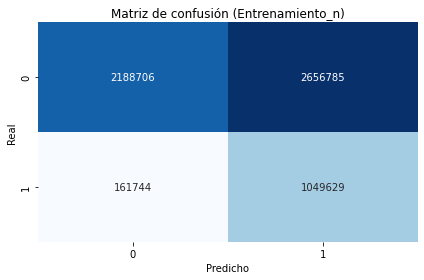

In [115]:
y_train_pred_LSTM_n = np.where(np.linalg.norm(X_train_3d_n - X_train_pred_LSTM_n, axis=(1, 2)) > threshold_u, 1, 0)

cm_test = confusion_matrix(y_train_n, y_train_pred_LSTM_n)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Matriz de confusión (Entrenamiento_n)')
plt.xlabel('Predicho')
plt.ylabel('Real')

plt.tight_layout()
plt.show()

In [116]:
classification_train = classification_report(y_train_n, y_train_pred_LSTM_n)
print('Classification Report (Train):\n', classification_train)

Classification Report (Train):
               precision    recall  f1-score   support

           0       0.93      0.45      0.61   4845491
           1       0.28      0.87      0.43   1211373

    accuracy                           0.53   6056864
   macro avg       0.61      0.66      0.52   6056864
weighted avg       0.80      0.53      0.57   6056864



In [117]:
name = input("Ingrese el nombre de los archivos a generar sin extención para el autoencoder_u: ")
model_json = autoencoder_u.to_json()
with open(f"{name}.json", "w") as json_file:
    json_file.write(model_json)
autoencoder_u.save_weights(f"{name}.h5")
print("Modelo guardado localmente")

Modelo guardado localmente


In [118]:
name = input("Ingrese el nombre de los archivos a generar sin extención para el autoencoder_n: ")
model_json = autoencoder_n.to_json()
with open(f"{name}.json", "w") as json_file:
    json_file.write(model_json)
autoencoder_n.save_weights(f"{name}.h5")
print("Modelo guardado localmente")

Modelo guardado localmente


### IF

Tiempo total de entrenamiento: 332.98 segundos
i = 3


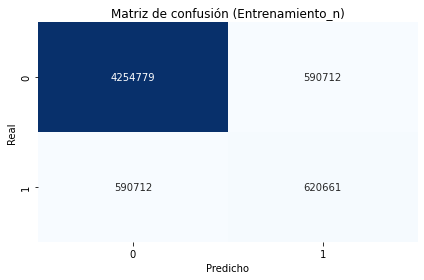

Classification Report (Train uniform):
               precision    recall  f1-score   support

           0       0.88      0.88      0.88   4845491
           1       0.51      0.51      0.51   1211373

    accuracy                           0.80   6056864
   macro avg       0.70      0.70      0.70   6056864
weighted avg       0.80      0.80      0.80   6056864

Tiempo total de entrenamiento: 301.95 segundos
i = 3


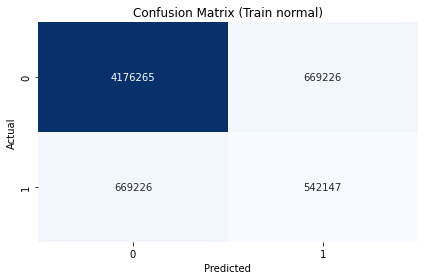

Classification Report (Train normal):
               precision    recall  f1-score   support

           0       0.86      0.86      0.86   4845491
           1       0.45      0.45      0.45   1211373

    accuracy                           0.78   6056864
   macro avg       0.65      0.65      0.65   6056864
weighted avg       0.78      0.78      0.78   6056864



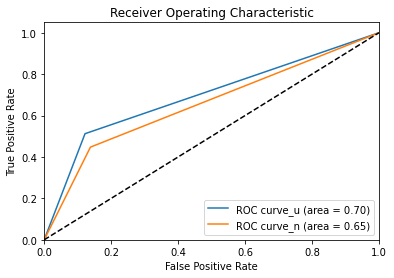

AUC_n: 0.6547171950636648
AUC_u: 0.6952259830467549


In [85]:
for i in range(3,4):
    # Modelo uniforme
    model_if_u = IsolationForest(n_estimators=120 , contamination=0.2, random_state=0)
    start_time = time.time()
    model_if_u.fit(data_train_X_u,data_train_X_u)
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Tiempo total de entrenamiento: {total_time:.2f} segundos")

    print("i =", i)
    X_train_pred_if_u = model_if_u.predict(data_train_X_u)
    X_train_pred_if_u = np.where(X_train_pred_if_u == 1, 0, np.where(X_train_pred_if_u == -1, 1, X_train_pred_if_u))
    cm_test = confusion_matrix(y_train_u, X_train_pred_if_u)

    # Matriz de confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title('Matriz de confusión (Entrenamiento_n)')
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

    # Cálculo de métricas
    classification_test = classification_report(y_train_u, X_train_pred_if_u)
    print('Classification Report (Train uniform):\n', classification_test)
    # ROC y AUC
    fpr_u, tpr_u, thresholds = roc_curve(y_train_u, X_train_pred_if_u)
    roc_auc_u = auc(fpr_u, tpr_u)

######################################################################################

    # Modelo normal
    model_if_n = IsolationForest(n_estimators=120 , contamination=0.2, random_state=0)
    start_time = time.time()
    model_if_n.fit(data_train_X_n,data_train_X_n)
    end_time = time.time()
    total_time = end_time - start_time
    print(f"Tiempo total de entrenamiento: {total_time:.2f} segundos")
    
    print("i =", i)
    X_train_pred_if_n = model_if_n.predict(data_train_X_n)
    X_train_pred_if_n = np.where(X_train_pred_if_n == 1, 0, np.where(X_train_pred_if_n == -1, 1, X_train_pred_if_n))
    threshold = 5

    cm_test = confusion_matrix(y_train_n, X_train_pred_if_n)

    # Matriz de confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
    plt.title('Confusion Matrix (Train normal)')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()

    # Calculo de las métricas
    classification_test = classification_report(y_train_n, X_train_pred_if_n)
    print('Classification Report (Train normal):\n', classification_test)

    # Curva ROC y AUC
    fpr_n, tpr_n, thresholds = roc_curve(y_train_n, X_train_pred_if_n)
    roc_auc_n = auc(fpr_n, tpr_n)
    plt.figure()
    plt.plot(fpr_u, tpr_u, label='ROC curve_u (area = %0.2f)' % roc_auc_u)
    plt.plot(fpr_n, tpr_n, label='ROC curve_n (area = %0.2f)' % roc_auc_n)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    print('AUC_n:', roc_auc_n)
    print('AUC_u:', roc_auc_u)

In [86]:
name = input("Ingrese el nombre de los archivos a generar sin extención para el modelo IF: ")
joblib.dump(model_if_u, f'{name}.joblib')
print("Modelo guardado localmente")

Modelo guardado localmente


In [87]:
name = input("Ingrese el nombre de los archivos a generar sin extención para el modelo IF: ")
joblib.dump(model_if_n, f'{name}.joblib')
print("Modelo guardado localmente")

Modelo guardado localmente
